# Content
- Introduction
- Hypothesis test for a mean (both σ known and unknown)
    - Traditional method
    - P-value method (probability value)
- Hypothesis test for a proportion (σ is not part of the formula)
- Hypothesis test for variance and standard deviation

In [4]:
# Imports
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import pylab

In [5]:
# Generic functions

def preferred_rounding(v, decimals=2):
    return str(round(v, decimals))

def display_probability_density_chart(
    cv_left=None,
    cv_right=None,
    test_value=None,
):
    r'''
    Display probability density chart.
    '''  
    fig, ax = plt.subplots(1, 1, figsize=(11, 5))
    
    # Standard normal distribution curve
    x = np.linspace(
        stats.norm.ppf(0.001),
        stats.norm.ppf(0.999), 
        100
    )
    curve = stats.norm.pdf(x)
        
    ax.plot(
        x, 
        curve,
        'r-', 
        color='#000000',
        lw=3, 
        alpha=0.8,
        label='Standard normal distribution curve'
    )
    
    # Critical region(s) in chart
    if cv_left:
        critical_region_left = np.linspace(-3.1, cv_left, 100)
        ax.fill_between(
            critical_region_left, 
            stats.norm.pdf(critical_region_left), 
            color='#f4c242', 
            alpha=0.5,
        )
        critical_value_left = np.linspace(cv_left-0.01, cv_left+0.01, 100)
        ax.fill_between(
            critical_value_left, 
            stats.norm.pdf(critical_value_left), 
            color='#f4c242', 
            alpha=1, 
            label='C.V. = ' + preferred_rounding(cv_left)
        )
        
    if cv_right:
        critical_region_right = np.linspace(cv_right, 3.1, 100)
        critical_value_right = np.linspace(cv_right-0.01, cv_right+0.01, 100)
        ax.fill_between(
            critical_value_right, 
            stats.norm.pdf(critical_value_right), 
            color='#f4c242', 
            alpha=1, 
            label='C.V. = ' + preferred_rounding(cv_right)
        )
        ax.fill_between(
            critical_region_right, 
            stats.norm.pdf(critical_region_right), 
            color='#f4c242', 
            alpha=0.5,
        )
       
    # Test value
    if test_value:
        ax.axvline(
            x=test_value, 
            linewidth=1.5, 
            color='#ff6666',
        )
        ax.text(
            x=test_value+.1, 
            y=0.2, 
            s='test value =' + preferred_rounding(test_value), 
            rotation=90,
        )
        
    ax.legend()
    plt.show()
    

def get_zscore_from_probability(
    p_left=None, # probability left side of target range (if any)
    p_right=None, # probability right side of target range (if any)    
):
    r'''
    Calculate z-score from table (with ppf).
    '''
    test_value = 0
    if p_left and not p_right:
        test_value = stats.norm.ppf(p_left)
        
    elif p_right and not p_left:
        test_value = 1 - stats.norm.ppf(p_right)
    
    elif p_left and p_right:
        test_value_left = stats.norm.ppf(p_left)
        test_value_right = stats.norm.ppf(p_right)
        test_value = test_value_right - test_value_left
    
    return test_value


def get_tscore_from_probability(
    p_left=None, # probability left side of target range (if any)
    p_right=None, # probability right side of target range (if any)
    df=0,
):
    r'''
    Calculate t-score from table (with ppf).
    '''
    test_value = 0
    if p_left and not p_right:
        test_value = stats.t.ppf(p_left, df)
        
    elif p_right and not p_left:
        test_value = 1 - stats.t.ppf(p_right, df)
    
    elif p_left and p_right:
        test_value_left = stats.t.ppf(p_left, df)
        test_value_right = stats.t.ppf(p_right, df)
        test_value = test_value_right - test_value_left
    
    return test_value

# Hypothesis test for a mean

In [6]:
def compute_hypothesis_test_for_mean(
    dataset=None,
    n=None,
    population_mean=None,
    population_std=None,
    sample_mean=None,
    sample_std=None,    
    tail='two-tailed',
    significance_level=.05,
    show_chart=False,
):
    r"""
    Conduct a statistical hypothesis test comparing a sample mean and population mean. 
    Works for σ known and unknown.
    The claim is the alternative hypothesis and the problem statement has to be formulated as such.
    """
    
    # Conditions to stop
    assert tail in ('two-tailed', 'right-tailed', 'left-tailed')
    
    ddof = 1
    if dataset:
        dataset_np = np.array(dataset)
        n = len(dataset_np) # sample size          
        sample_mean = np.mean(dataset_np) # sample mean
        sample_std = np.std(dataset_np, ddof=ddof) # sample STD
        
    df = n-ddof # degree of freedom
    
    # Parameters and statistics
    print('Parameters and statistics')    
    print('-------------------------')
    print('Population mean =', population_mean)
    print('Population STD =', population_std)
    print('Sample mean =', sample_mean)
    print('Sample STD =', sample_std)        
    print('Sample size =', n)
    print('Significance level =', significance_level)
    print('Test type =', tail)
    
    # 1. Hypothesis
    print()
    print('1. Hypothesis')
    sample_mean_supports_claim = False
    if tail == 'two-tailed':
        operator = '≠'
        operator_label = 'different from'
        if sample_mean != population_mean:
            sample_mean_supports_claim = True
    elif tail == 'right-tailed':
        operator = '>'
        operator_label = 'more than'
        if sample_mean > population_mean:
            sample_mean_supports_claim = True
    elif tail == 'left-tailed':
        operator = '<'
        operator_label = 'less than'
        if sample_mean < population_mean:
            sample_mean_supports_claim = True
    
    # Statement
    h0 = 'H0: μ = ' + str(population_mean)
    h1 = 'H1: μ ' + operator + ' ' + str(population_mean)    
    print(h0, 'and', h1, '(claim)')
    
    # 2. Critical value(s)
    print()
    print('2. Critical value(s)')
    cv_left, cv_right = None, None
    tailed_alpha = significance_level
    
    if population_std: # When σ known
        if tail == 'two-tailed':
            tailed_alpha = significance_level/2
            cv_right = abs(get_zscore_from_probability(p_left=tailed_alpha))
            cv_left = -cv_right
            print('C.V. =', '±' + preferred_rounding(cv_right), '(two-tailed)')
        elif tail == 'right-tailed':
            cv_right= get_zscore_from_probability(p_right=tailed_alpha)
            print('C.V. =', preferred_rounding(cv_right), '(right-tailed)')
        elif tail == 'left-tailed':
            cv_left = get_zscore_from_probability(p_left=tailed_alpha)
            print('C.V. =', preferred_rounding(cv_left), '(left-tailed)')
            
    else: # When σ unknown
        if tail == 'two-tailed':
            tailed_alpha = significance_level/2
            cv_right = abs(get_tscore_from_probability(p_left=tailed_alpha, df=df))
            cv_left = -cv_right
            print('C.V. =', '±' + preferred_rounding(cv_right), '(two-tailed)')
        elif tail == 'right-tailed':
            cv_right= get_tscore_from_probability(p_right=tailed_alpha, df=df)
            print('C.V. =', preferred_rounding(cv_right), '(right-tailed)')
        elif tail == 'left-tailed':
            cv_left = get_tscore_from_probability(p_left=tailed_alpha, df=df)
            print('C.V. =', preferred_rounding(cv_left), '(left-tailed)')
    
    # 3. Test value, P-value and chart
    print()
    print('3. Test value, P-value and chart')
    
    # Hypothesis test for a mean
    if population_std: # When σ known
        print('Test type: z test')
        standard_error = population_std/np.sqrt(n)
        test_value = (sample_mean-population_mean)/standard_error
    else: # When σ unknown 
        print('Test type: t test')
        standard_error = sample_std/np.sqrt(n)
        test_value = (sample_mean-population_mean)/standard_error 

    # Calculate P-value
    if population_std: # When σ known
        p_value = stats.norm.sf(abs(test_value))     
    else: # When σ unknown 
        p_value = stats.t.sf(abs(test_value), df=df) 
    if tail == 'two-tailed':   
        p_value = p_value*2 
    print('test value = ', preferred_rounding(test_value))
    print('P-value = ', preferred_rounding(p_value, 4))
    
    # Chart
    if show_chart:
        display_probability_density_chart(
            cv_left=cv_left,
            cv_right=cv_right,
            test_value=test_value,
        )
        
    # 4a. Result and decision (traditional method)
    print()
    print('4a. Result and decision (traditional method)')
    
    decision_statement = 'reject'
    evidence_statement = 'enough evidence'
    if cv_left and cv_right:
        if (test_value < 0 and cv_left < test_value) or (test_value > 0 and cv_right > test_value):
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_left:
        if cv_left < test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_right:
        if cv_right > test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
            
    print('The decision is to', decision_statement, 'the null hypothesis.')
    
    claim = 'μ is ' + operator_label + ' ' + str(population_mean)
    print('There is', evidence_statement, 'to support the claim that', claim, 
          'with a significance level of', str(significance_level) + '.')
  
    print()
    if decision_statement == 'reject':
        print('Although the difference between sample mean and population mean is said to be significant, there is a risk of a type I error',
              '(rejecting H0 althought it is true).')
        print('In this case, the probability of a type I error is', '{:0.0f}%'.format(significance_level*100) + '.')
        print('You could try to reduce the significance level to decrease the probability of a type I error.')
        
    elif decision_statement == 'not reject':
        print('Although the difference between sample mean and population mean is not significant, there is a risk of a type II error',
              '(not rejecting H0 althought it is false).')
        print('You could try to increase the significance level to decrease the probability of a type II error.', 
              'However, this would increase the probability of a type I error')
        
        if sample_mean_supports_claim:
            print('Note that even though sample mean of', sample_mean, 'is', operator_label, population_mean,
                 'it is not significantly different and might be due to chance.')
            
    
    # 4b. Result and decision (P-value method)
    print()
    print('4b. Result and decision (P-value method)')
    if p_value <= tailed_alpha:
        decision_statement_p_value_method = 'reject'
        print('P-value ≤ ∝, therefore we reject H0.')
    else:
        decision_statement_p_value_method = 'not reject'
        print('P-value > ∝, therefore we do NOT reject H0.')  
        
    # 5. Summary
    print()
    print('5. Summary')
    if decision_statement == decision_statement_p_value_method:
        print('The traditional method and P-value method support the same conclusion.')
    else:
        print('The traditional method and P-value method do NOT support the same conclusion.')

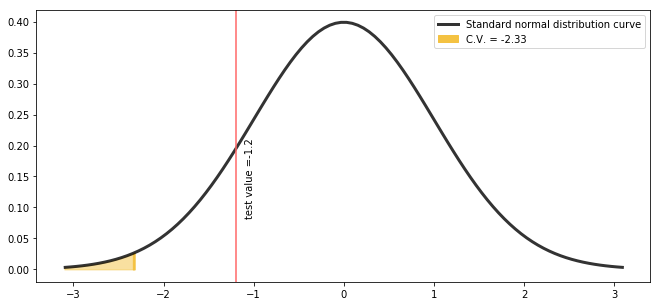

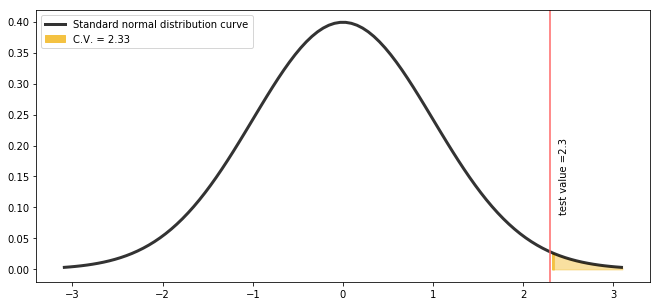

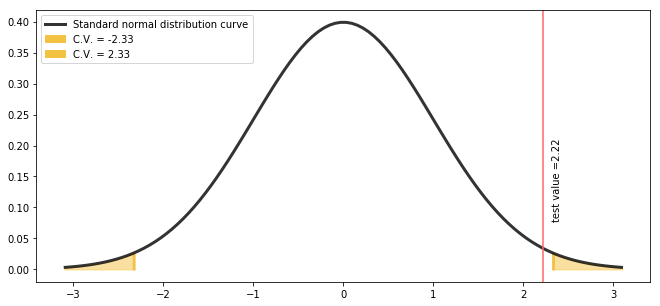

In [7]:
# left-tailed
display_probability_density_chart(
    cv_left=-2.33,
    cv_right=None,
    test_value=-1.2,
)

# right-tailed
display_probability_density_chart(
    cv_left=None,
    cv_right=2.33,
    test_value=2.3,
)

# two-tailed
display_probability_density_chart(
    cv_left=-2.33,
    cv_right=2.33,
    test_value=2.22,
)

# Introduction

Hypothesis testing is used to answer questions such as: **is there a real difference between a sample mean and a population mean or is it due to a sampling error** (happened by chance)?

Hypothesis testing supports the decision-making process for evaluating claims about a population.

## Use case
Very useful to proove that a sample is different from a population. 
**E.g. students who complete data science ABC online class have a higher mean score than mean of entire student batch including students who did not take the class.**

## Process
1. Define population under study
2. State hypothesis that will be investigated (H0 and H1)
3. Define significance level alpha (how much do we want to risk committing a Type I error?)
4. Select sample from population
5. Collect data
6. Run statistical tests
7. Reach a conclusion

## Methods
There are 3 methods:
- Traditional method
- P-value method
- Confidence interval method

# Traditional method

## Definitions

**Statistical hypothesis**: conjecture (conclusion formed on the basis of incomplete information) about a population parameter (distribution or randomness) that may be true or false.

**Null hypothesis (H0)**: states that there is **NO difference** between a parameter and a specific value, or that there is NO difference between 2 parameters. E.g. H0: μ = 82

**Alternative hypothesis (H1)**: states that there is a **difference** between a parameter and a specific value, or that there is difference between 2 parameters. E.g. H0: μ <> 82

## Test types
There are 3 test types:
1. H0: μ = ? and H1: μ <> ? => two-tailed test (z for ∝/2 and 1-∝/2)
2. H0: μ = ? and H1: μ > ? => right-tailed test (z for 1-∝)
3. H0: μ = ? and H1: μ < ? => left-tailed test (z for ∝)

## How to state a conclusion?
Depending on our target conclusion:
- The claim should be stated as **H1** if we want statistical evidence to **support the claim**.
- The claim should be stated as **H0** if we want statistical evidence to **reject the claim**.

Either H0 is true, and the difference was due to chance, or false (i.e. H1 is true), and the sample mean is truely different from the population mean.

## How to draw a line for conclusion?
**To decide whether to reject or not reject H0, the difference must be significant** after applying the chosen statistical tests (use data from sample to make decision about H0) with a defined level of significance.

**Test value**: the numerical value obtained from a statistical test. Computed from z-test and t-test.

## Possible outcomes

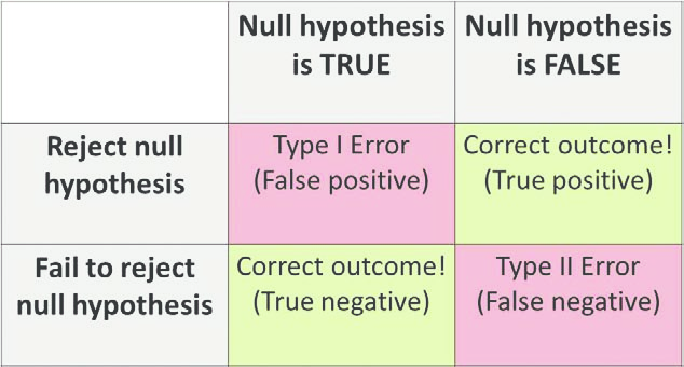

Error types:
- **Type I error**: we reject H0 when it is true (false positive).
- **Type II error**: we do not reject H0 when it is false (false negative).

Type I and Type II errors have a negative correlation.

P(type I error) = ∝ (alpha is the significance level)

P(type II error) = β (not easy to compute)


## Critical value

C.V. separates the critical region (rejection region) from noncritical region.

E.g. C.V. for ∝ = 0.05 and ∝ = 0.01 for right-tailed test.

**We reject H0 when the test value is within the critical region.**

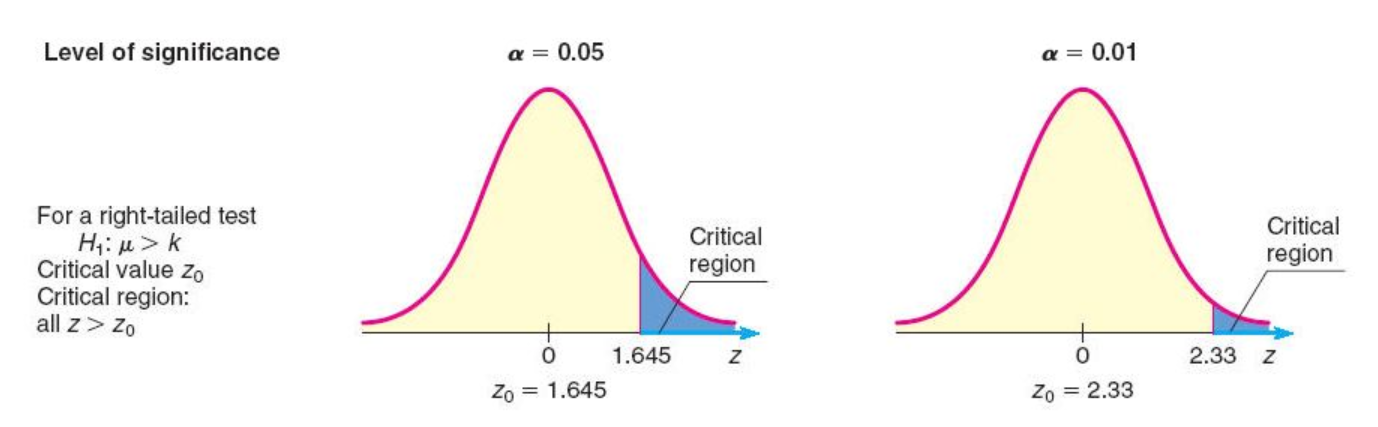

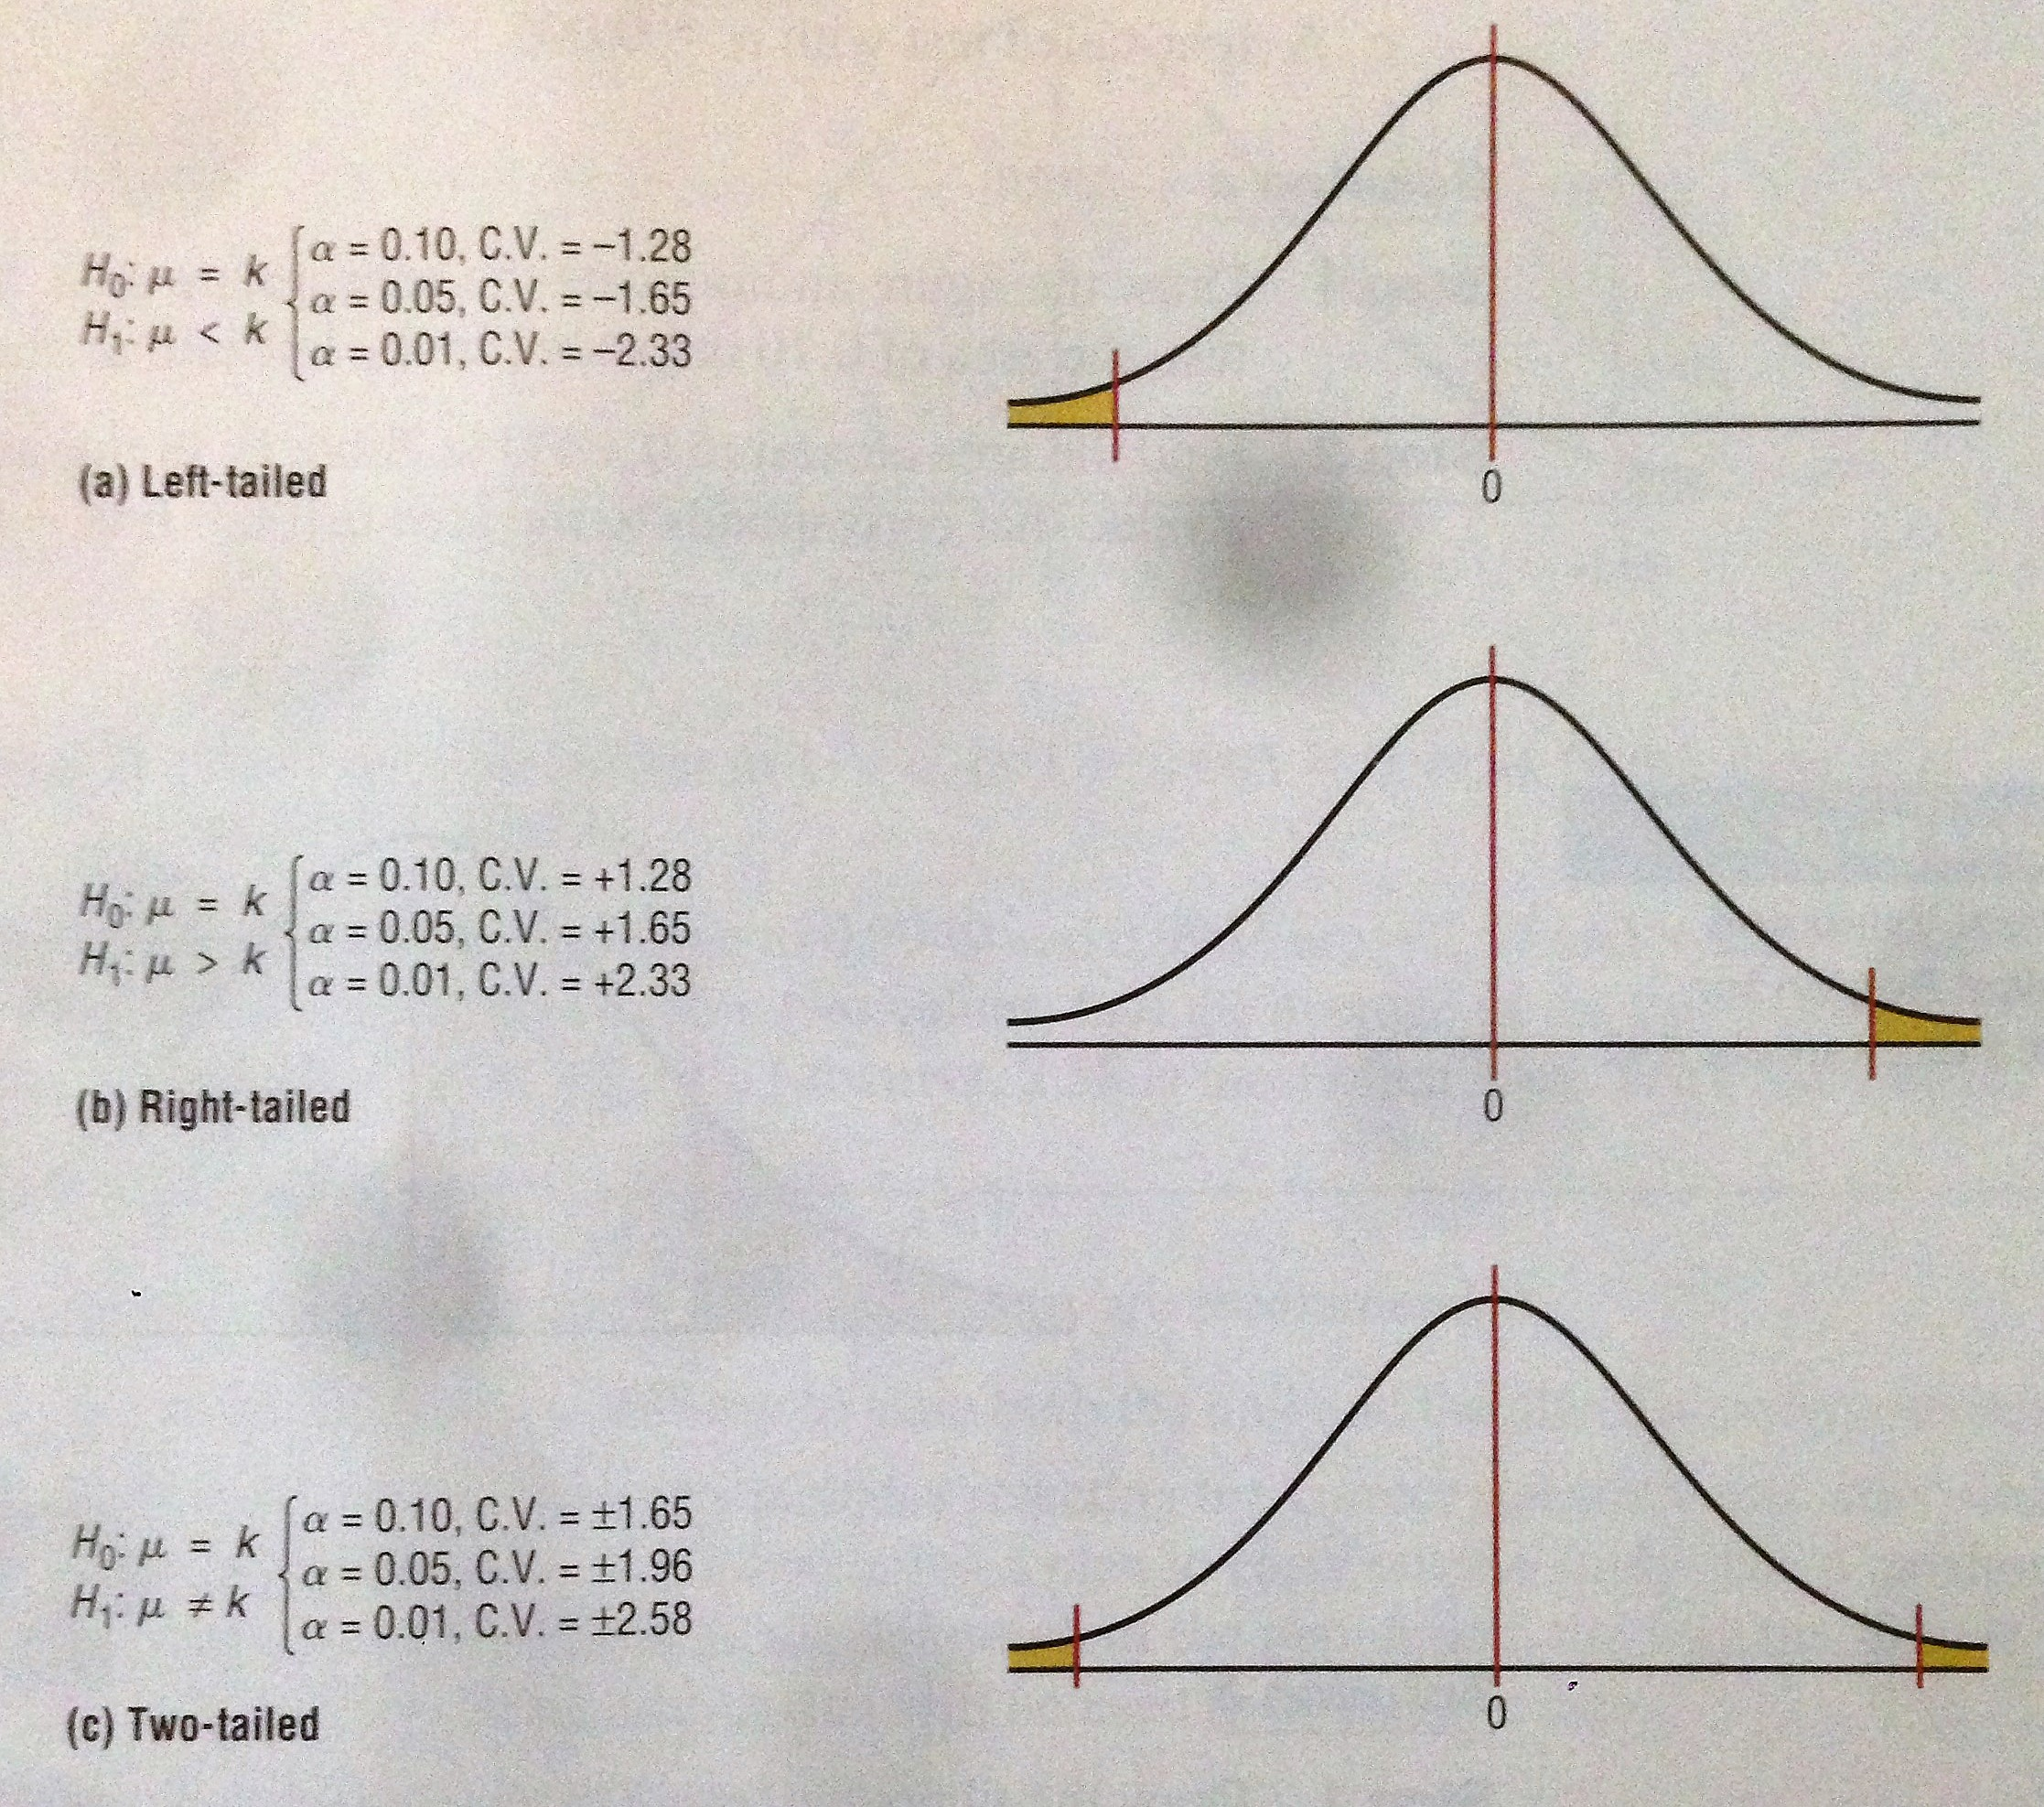

## Test means when sigma is known (z test for mean)

### Assumptions

- Sample is random sample
- n >= 30 or population is normally distributed with n < 30
- Sigma known

### Formula
**Test value** = [(observerd value)-(expected value)]/standard error

**observerd value** is calculated from z test or t test.

**expected value** is the parameter from the population that we would expect if H0 is true.

test value = z = (X-μ)/(σ/√n)

### Note
When H0 is not rejected, it does not mean that it is true. It only means there is not enough evidence to reject it.

## Examples

Parameters and statistics
-------------------------
Population mean = 80
Population STD = 19.2
Sample mean = 75.0
Sample STD = 19.16097223897726
Sample size = 36
Significance level = 0.05
Test type = left-tailed

1. Hypothesis
H0: μ = 80 and H1: μ < 80 (claim)

2. Critical value(s)
C.V. = -1.64 (left-tailed)

3. Test value, P-value and chart
Test type: z test
test value =  -1.56
P-value =  0.0591


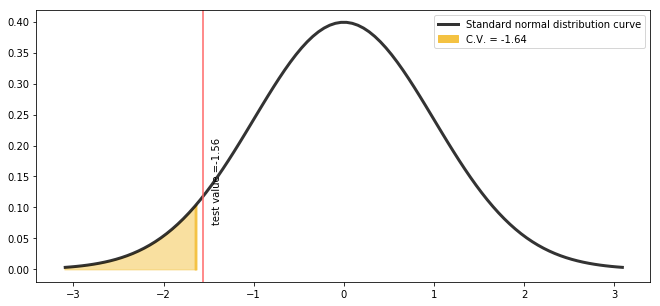


4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that μ is less than 80 with a significance level of 0.05.

Although the difference between sample mean and population mean is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error
Note that even though sample mean of 75.0 is less than 80 it is not significantly different and might be due to chance.

4b. Result and decision (P-value method)
P-value > ∝, therefore we do NOT reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [8]:
# Researcher claims that average cost of men's athletic shoes is less than $80.
# He selects random sample of 36 pairs from a catalog with below costs.
# Is there enough evidence to support the claim at ∝=0.10? σ=19.2 

shoes_cost_list = [
    60, 70, 75, 55, 80, 55,
    50, 40, 80, 70, 50, 95,
    120, 90, 75, 85, 80, 60,
    110, 65, 80, 85, 85, 45,
    75, 60, 90, 90, 60, 95,
    110, 85, 45, 90, 70, 70,
]

compute_hypothesis_test_for_mean(
    shoes_cost_list,
    population_mean=80,
    population_std=19.2,
    tail='left-tailed',
    significance_level=.05,
    show_chart=True,
)

Parameters and statistics
-------------------------
Population mean = 24672
Population STD = 3251
Sample mean = 26343
Sample STD = None
Sample size = 35
Significance level = 0.01
Test type = two-tailed

1. Hypothesis
H0: μ = 24672 and H1: μ ≠ 24672 (claim)

2. Critical value(s)
C.V. = ±2.58 (two-tailed)

3. Test value, P-value and chart
Test type: z test
test value =  3.04
P-value =  0.0024


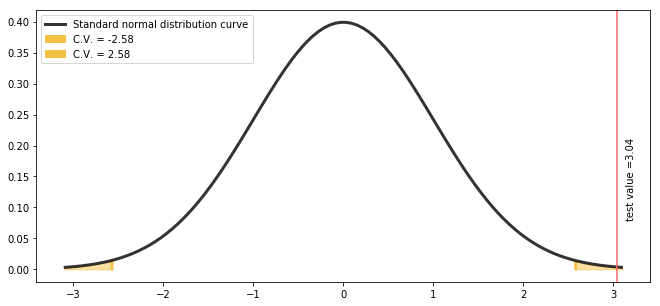


4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that μ is different from 24672 with a significance level of 0.01.

Although the difference between sample mean and population mean is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 1%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value method)
P-value ≤ ∝, therefore we reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [9]:
# Researcher wants to find out if average costs of rehabilitation after stroke is different
# for his hospital than from a report covering all hospitals of the country.

compute_hypothesis_test_for_mean(
    dataset=None,
    n=35,
    sample_mean=26343,
    population_mean=24672,
    population_std=3251,
    tail='two-tailed',
    significance_level=.01,
    show_chart=True,
)

## Test means when sigma is unknown (t test for mean)

The t test is a test for the mean of a population and is used when the population STD is unknown.

### Assumptions

- Sample is random sample
- n >= 30 or population is normally distributed with n < 30
- Sigma unknown

### Formula
test value = t = (X-μ)/(s/√n)

s = sample_std = np.std(dataset_np, ddof=1)

d.f. = n-1

### Examples

Parameters and statistics
-------------------------
Population mean = 16.3
Population STD = None
Sample mean = 17.7
Sample STD = 1.8
Sample size = 10
Significance level = 0.05
Test type = two-tailed

1. Hypothesis
H0: μ = 16.3 and H1: μ ≠ 16.3 (claim)

2. Critical value(s)
C.V. = ±2.26 (two-tailed)

3. Test value, P-value and chart
Test type: t test
test value =  2.46
P-value =  0.0362


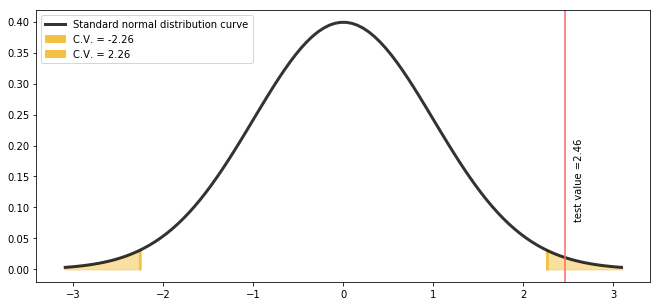


4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that μ is different from 16.3 with a significance level of 0.05.

Although the difference between sample mean and population mean is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value method)
P-value > ∝, therefore we do NOT reject H0.

5. Summary
The traditional method and P-value method do NOT support the same conclusion.


In [10]:
# Medical investigation claims that average infections per week at hospital A is 16.3.
# Random sample of 10 weeks had a mean number of 17.7 infections.
# The sample STD is 1.8. Is there enough evidence to reject the investigator's claim?
# Alpha = 0.05

compute_hypothesis_test_for_mean(
    dataset=None,
    n=10, # data must be follow a normal distribution
    sample_mean=17.7,
    sample_std=1.8,
    population_mean=16.3,
    population_std=None, # apply t test since sigma unknow
    tail='two-tailed',
    significance_level=.05,
    show_chart=True,
)

Parameters and statistics
-------------------------
Population mean = 60
Population STD = None
Sample mean = 58.875
Sample STD = 5.0832357523811265
Sample size = 8
Significance level = 0.1
Test type = left-tailed

1. Hypothesis
H0: μ = 60 and H1: μ < 60 (claim)

2. Critical value(s)
C.V. = -1.41 (left-tailed)

3. Test value, P-value and chart
Test type: t test
test value =  -0.63
P-value =  0.2756


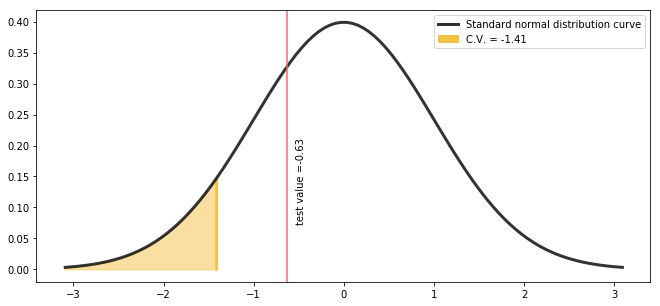


4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that μ is less than 60 with a significance level of 0.1.

Although the difference between sample mean and population mean is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error
Note that even though sample mean of 58.875 is less than 60 it is not significantly different and might be due to chance.

4b. Result and decision (P-value method)
P-value > ∝, therefore we do NOT reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [11]:
# Teacher claims that average salary of teachers is less than $60 per day.
# Random sample of 8 below. Is there enough evidence to support the claim?
# Alpha = 0.10

salary_list = [60, 56, 60, 55, 70, 55, 60, 55]

compute_hypothesis_test_for_mean(
    dataset=salary_list,
    population_mean=60,
    population_std=None, # apply t test since sigma unknow
    tail='left-tailed',
    significance_level=.1,
    show_chart=True,
)

# P-value method

**P-value** (probability value): probability of getting a sample statistic (e.g. mean) in the direction of the alternative hypothesis when the null hypothesis is true.

## Rule

If P-value ≤ ∝, reject H0

If P-value > ∝, do NOT reject H0

## Examples

Parameters and statistics
-------------------------
Population mean = 5700
Population STD = 659
Sample mean = 5950
Sample STD = None
Sample size = 36
Significance level = 0.05
Test type = right-tailed

1. Hypothesis
H0: μ = 5700 and H1: μ > 5700 (claim)

2. Critical value(s)
C.V. = 2.64 (right-tailed)

3. Test value, P-value and chart
Test type: z test
test value =  2.28
P-value =  0.0114


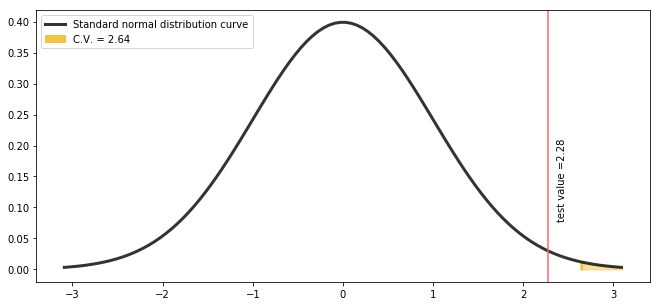


4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that μ is more than 5700 with a significance level of 0.05.

Although the difference between sample mean and population mean is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value method)
P-value ≤ ∝, therefore we reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [12]:
# Researcher wants to find out if average costs of tuition fees is greater than $5700
# Random sample of 36 colleges with mean of $5950.
# Population std is $659. Alpha is 0.05.
# Use P-value method

compute_hypothesis_test_for_mean(
    dataset=None,
    n=36,
    sample_mean=5950,
    population_mean=5700,
    population_std=659,
    tail='right-tailed',
    significance_level=.05,
    show_chart=True,
)

Normality assessment


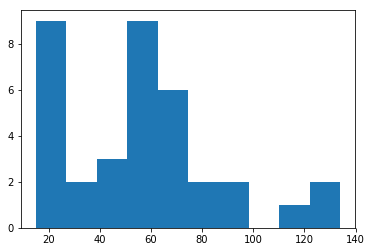

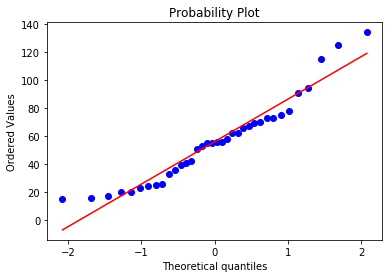

Data does not appear to follow a normal distribution, but since sample size > 30 we can continue.

Parameters and statistics
-------------------------
Population mean = 44
Population STD = 30.3
Sample mean = 55.97222222222222
Sample STD = 30.29520104487188
Sample size = 36
Significance level = 0.05
Test type = two-tailed

1. Hypothesis
H0: μ = 44 and H1: μ ≠ 44 (claim)

2. Critical value(s)
C.V. = ±1.96 (two-tailed)

3. Test value, P-value and chart
Test type: z test
test value =  2.37
P-value =  0.0178


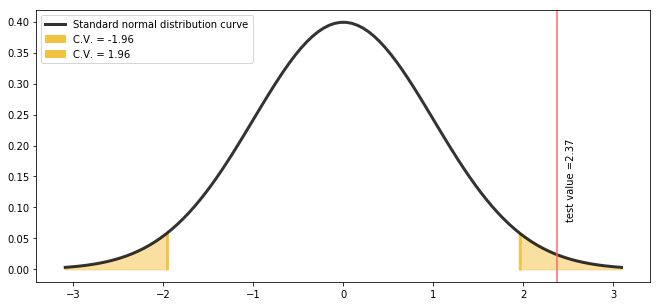


4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that μ is different from 44 with a significance level of 0.05.

Although the difference between sample mean and population mean is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value method)
P-value ≤ ∝, therefore we reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [13]:
# Person wants to do advertising campaign for a car antitheft device.
# Last year, rate of theft per 10K cars was 44.
# Our claim is that the rate has changed this year.
# Is there enough evidence to support the claim at ∝=0.05? σ=30.3

car_theft_per_city_list = [
    55, 42, 125, 62, 134, 73,
    39, 69, 23, 94, 73, 24,
    51, 55, 26, 66, 41, 67,
    15, 53, 56, 91, 20, 78,
    70, 25, 62, 115, 17, 36,
    58, 56, 33, 75, 20, 16,
]

print('Normality assessment')
plt.hist(
    sorted(car_theft_per_city_list),
)
plt.show()
stats.probplot(car_theft_per_city_list, dist="norm", plot=pylab)
pylab.show()

print('Data does not appear to follow a normal distribution, but since sample size > 30 we can continue.')
print()

compute_hypothesis_test_for_mean(
    car_theft_per_city_list,
    population_mean=44,
    population_std=30.3,
    tail='two-tailed',
    significance_level=.05,
    show_chart=True,
)

Parameters and statistics
-------------------------
Population mean = 36.7
Population STD = None
Sample mean = 40.6
Sample STD = 6
Sample size = 15
Significance level = 0.05
Test type = right-tailed

1. Hypothesis
H0: μ = 36.7 and H1: μ > 36.7 (claim)

2. Critical value(s)
C.V. = 2.76 (right-tailed)

3. Test value, P-value and chart
Test type: t test
test value =  2.52
P-value =  0.0123


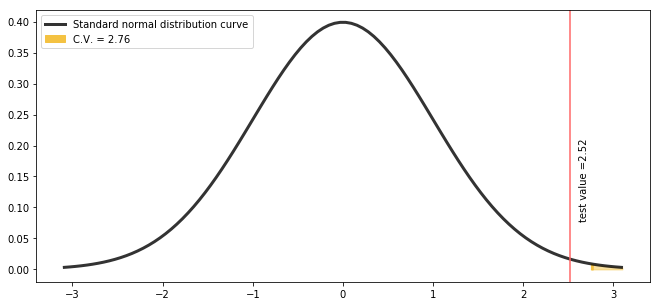


4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that μ is more than 36.7 with a significance level of 0.05.

Although the difference between sample mean and population mean is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value method)
P-value ≤ ∝, therefore we reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [14]:
# With t test (interesting problem)

# Physician claims that joggers' max oxygen volume is greater than average of all adults.
# Sample of 15 joggers with mean of 40.6 ml/kg and a STD of 6 ml/kg.
# Average adult has 36.7 ml/kg. Enough evidence at alpha = 0.05?

compute_hypothesis_test_for_mean(
    dataset=None,
    n=15, # data must follow a normal distribution
    sample_mean=40.6,
    sample_std=6,
    population_mean=36.7,
    population_std=None, # apply t test since sigma unknow
    tail='right-tailed',
    significance_level=.05,
    show_chart=True,
)

# Hypothesis test for a proportion

## z Test for a proportion

### Theory

Hypothesis test involving population proportion **can be considered as a binomial experiment** when there are only two outcomes and the probability of success does not change from trial to trial.

Since the normal distribution can be used to approximate the binomial distribution when np >= 5 and nq >= 5, we can use the **standard normal distribution for testing the hypothesis for proportions**.

### Formula

z = (p̂-p)/√(p̂q̂/n)

- p̂ = X/n = sample proportion
- p = population proportion

In [15]:
def compute_hypothesis_test_for_proportion(
    dataset=None,
    n=None,
    p=None, # only for proportion target
    X=None, # only for proportion target
    tail='two-tailed',
    significance_level=.05,
    show_chart=False,
):
    r"""
    Conduct a statistical hypothesis test comparing a sample proportion and population proportion. 
    The claim is the alternative hypothesis and the problem statement has to be formulated as such.
    """
    
    ddof = 1
    if dataset:
        dataset_np = np.array(dataset)
        n = len(dataset_np) # sample size
        
    df = n-ddof # degree of freedom
    q = 1-p
    p_hat = X / n
    
    # Parameters and statistics
    print('Parameters and statistics')    
    print('-------------------------')
    print('p =', p)
    print('q =', q)
    print('n =', n)
    print('p*n =', p*n)
    print('q*n =', q*n)
    print('X =', X)   
    print('alpha =', significance_level)
    print('Test type =', tail)
    
    # Conditions to stop
    assert tail in ('two-tailed', 'right-tailed', 'left-tailed')
    if n*p >= 5 and n*q >= 5:
        print('Assumptions for testing a proportion are satisfied.')
    else:
        print('Assumptions for testing a proportion are NOT satisfied!')
        return False
    
    # 1. Hypothesis
    print()
    print('1. Hypothesis')
    sample_supports_claim = False
    if tail == 'two-tailed':
        operator = '≠'
        operator_label = 'different from'
        if p_hat != p:
            sample_supports_claim = True
    elif tail == 'right-tailed':
        operator = '>'
        operator_label = 'more than'
        if p_hat > p:
            sample_supports_claim = True
    elif tail == 'left-tailed':
        operator = '<'
        operator_label = 'less than'
        if p_hat < p:
            sample_supports_claim = True
    
    # Statement
    h0 = 'H0: p = ' + str(p)
    h1 = 'H1: p ' + operator + ' ' + str(p)   
    print(h0, 'and', h1, '(claim)')
    
    # 2. Critical value(s)
    print()
    print('2. Critical value(s)')
    cv_left, cv_right = None, None
    tailed_alpha = significance_level
    
    if tail == 'two-tailed':
        tailed_alpha = significance_level/2
        cv_right = abs(get_zscore_from_probability(p_left=tailed_alpha))
        cv_left = -cv_right
        print('C.V. =', '±' + preferred_rounding(cv_right), '(two-tailed)')
    elif tail == 'right-tailed':
        cv_right= get_zscore_from_probability(p_right=tailed_alpha)
        print('C.V. =', preferred_rounding(cv_right), '(right-tailed)')
    elif tail == 'left-tailed':
        cv_left = get_zscore_from_probability(p_left=tailed_alpha)
        print('C.V. =', preferred_rounding(cv_left), '(left-tailed)')
            

    # 3. Test value and chart
    print()
    print('3. Test value and chart')
    
    # Hypothesis test for a proportion
    print('Test type: z test')
    print('We use the standard normal distribution to approximate the binomial distribution.')

    standard_error = np.sqrt(p*q/n)
    test_value = (p_hat-p)/standard_error   
    print('test value = ', preferred_rounding(test_value))
 
    # Chart
    if show_chart:
        display_probability_density_chart(
            cv_left=cv_left,
            cv_right=cv_right,
            test_value=test_value,
        )
        
    # 4. Result and decision (traditional method)
    print()
    print('4. Result and decision (traditional method)')
    
    decision_statement = 'reject'
    evidence_statement = 'enough evidence'
    if cv_left and cv_right:
        if (test_value < 0 and cv_left < test_value) or (test_value > 0 and cv_right > test_value):
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_left:
        if cv_left < test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_right:
        if cv_right > test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
            
    print('The decision is to', decision_statement, 'the null hypothesis.')
    
    claim = 'p is ' + operator_label + ' ' + str(p)
    print('There is', evidence_statement, 'to support the claim that', claim, 
          'with a significance level of', str(significance_level) + '.')
  
    print()
    if decision_statement == 'reject':
        print('Although the difference between sample proportion and population proportion is said to be significant, there is a risk of a type I error',
              '(rejecting H0 althought it is true).')
        print('In this case, the probability of a type I error is', '{:0.0f}%'.format(significance_level*100) + '.')
        print('You could try to reduce the significance level to decrease the probability of a type I error.')
        
    elif decision_statement == 'not reject':
        print('Although the difference between sample proportion and population proportion is not significant, there is a risk of a type II error',
              '(not rejecting H0 althought it is false).')
        print('You could try to increase the significance level to decrease the probability of a type II error.', 
              'However, this would increase the probability of a type I error')
        
        if sample_supports_claim:
            print('Note that even though sample proportion of', p_hat, 'is', operator_label, p,
                 'it is not significantly different and might be due to chance.')
            

Parameters and statistics
-------------------------
p = 0.6
q = 0.4
n = 200
p*n = 120.0
q*n = 80.0
X = 128
alpha = 0.05
Test type = two-tailed
Assumptions for testing a proportion are satisfied.

1. Hypothesis
H0: p = 0.6 and H1: p ≠ 0.6 (claim)

2. Critical value(s)
C.V. = ±1.96 (two-tailed)

3. Test value and chart
Test type: z test
We use the standard normal distribution to approximate the binomial distribution.
test value =  1.15


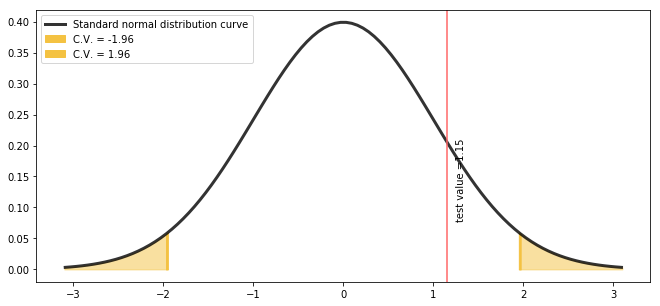


4. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that p is different from 0.6 with a significance level of 0.05.

Although the difference between sample proportion and population proportion is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error
Note that even though sample proportion of 0.64 is different from 0.6 it is not significantly different and might be due to chance.


In [16]:
# Researcher claims that 60% of people are trying to avoid trans fats in their diets.
# Randomly selects 200 people and found that 128 people stated they are trying to avoid.
# At alpha = 0.05, is there enough evidence to reject the claim?

compute_hypothesis_test_for_proportion(
    dataset=None,
    n=200,
    p=.6,
    X=128,
    tail='two-tailed',
    significance_level=.05,
    show_chart=True,
)

# Hypothesis test for variance and standard deviation

Here we use the chi-square distribution (χ2), which is skewed to the right.

## Application
Testing variances is very useful in **situations where consistency is required**.

For example manufacturing of bolts for which the variation in diameter should be kept to a minimum.

## Assumptions

- Sample is random sample from the population
- Population must be normally distributed
- Observations must be independent from one another


## Formula

X² = df*s²/σ²

In [17]:
def compute_chi_square(
    n=None,
    df=None,
    alpha=None,
    tail='two-tailed',
):
    # Conditions
    assert tail in ('two-tailed', 'right-tailed', 'left-tailed')
    
    # Degree of freedom
    if n and not df:
        df = n - 1
    
    if tail == 'two-tailed':
        alpha_half = alpha / 2
        chi_square_right = stats.chi2.isf(alpha_half, df)
        chi_square_left = stats.chi2.isf(1-alpha_half, df)
        return chi_square_right, chi_square_left
    
    elif tail == 'right-tailed':
        return stats.chi2.isf(alpha, df)
        
    elif tail == 'left-tailed':
        return stats.chi2.isf(1-alpha, df)

In [18]:
chi_square_right = compute_chi_square(
    df=15,
    alpha=.05,
    tail='right-tailed',
)
print('chi-square right:', round(chi_square_right, 2))

chi-square right: 25.0


In [23]:
df = 22
chi_square_right, chi_square_left = compute_chi_square(
    df=df,
    alpha=.05,
    tail='two-tailed',
)
print('chi-square left:', round(chi_square_left, 2))
print('chi-square right:', round(chi_square_right, 2))

chi-square left: 10.98
chi-square right: 36.78


In [93]:
def compute_hypothesis_test_for_consistency(
    dataset=None,
    n=None,
    sample_variance=None,
    sample_std=None,
    population_variance=None,
    population_std=None,
    tail='two-tailed',
    significance_level=.05,
):
    r"""
    Conduct a statistical hypothesis test comparing a sample variance and population variance. 
    The claim is the alternative hypothesis and the problem statement has to be formulated as such.
    """ 
    
    ddof = 1
    if dataset:
        dataset_np = np.array(dataset)
        n = len(dataset_np) # sample size
        sample_variance = np.var(dataset_np, ddof=ddof)
        sample_std = np.std(dataset_np, ddof=ddof)     
        
    # Conditions to stop
    assert tail in ('two-tailed', 'right-tailed', 'left-tailed')
    assert population_variance or population_std
        
    if population_variance:
        population_std = np.sqrt(population_variance)
        statistic_symbol = 'σ²'
        statistic_label = 'variance'
        hypothesis_value = population_variance
    elif population_std:
        population_variance = np.power(population_std, 2)
        statistic_symbol = 'σ'
        statistic_label = 'standard deviation'
        hypothesis_value = population_std
        
    if sample_variance:
        sample_std = np.sqrt(sample_variance)
    elif sample_std:
        sample_variance = np.power(sample_std, 2)
    
    df = n-ddof # degree of freedom
    
    # Parameters and statistics
    print('Parameters and statistics')    
    print('-------------------------')
    print('n =', n)
    print('df =', df)
    print('sample variance (s²) =', sample_variance)
    print('sample std (s) =', sample_variance)
    print('population variance (σ²) =', population_variance)   
    print('population std (σ) =', population_std) 
    print('alpha =', significance_level)
    print('test type =', tail)
    
    
    # 1. Hypothesis
    print()
    print('1. Hypothesis')
    sample_supports_claim = False
    if tail == 'two-tailed':
        operator = '≠'
        operator_label = 'different from'
    elif tail == 'right-tailed':
        operator = '>'
        operator_label = 'more than'
    elif tail == 'left-tailed':
        operator = '<'
        operator_label = 'less than'
    
    # Statement
    h0 = 'H0: ' + statistic_symbol + ' = ' + str(hypothesis_value)
    h1 = 'H1: ' + statistic_symbol + ' = ' + str(hypothesis_value) 
    print(h0, 'and', h1, '(claim)')
    
    # 2. Critical value(s)
    print()
    print('2. Critical value(s)')
    cv_left, cv_right = None, None
    tailed_alpha = significance_level
    
    if tail == 'two-tailed':
        cv_right, cv_left = compute_chi_square(
            df=df,
            alpha=tailed_alpha,
            tail='two-tailed',
        )
        print('C.V. left =', preferred_rounding(cv_left), '(two-tailed)')
        print('C.V. right =', preferred_rounding(cv_right), '(two-tailed)')
    elif tail == 'right-tailed':
        cv_right = compute_chi_square(
            df=df,
            alpha=tailed_alpha,
            tail='right-tailed',
        )
        print('C.V. =', preferred_rounding(cv_right), '(right-tailed)')
    elif tail == 'left-tailed':
        cv_left = compute_chi_square(
            df=df,
            alpha=tailed_alpha,
            tail='left-tailed',
        )
        print('C.V. =', preferred_rounding(cv_left), '(left-tailed)')
            

    # 3. Test value
    print()
    print('3. Test value')
    
    # Hypothesis test for a variance or 
    print('Test type: Chi-square test')

    # test value
    standard_error = population_variance
    test_value = (df*sample_variance)/standard_error 
    
    # P-value
    p_value = stats.chi2.cdf(test_value, df)
    if p_value >= .5:
        p_value = 1 - stats.chi2.cdf(test_value, df)
    if tail == 'two-tailed':      
        p_value = p_value*2 
        
    print('test value = ', preferred_rounding(test_value))
    print('P-value =', preferred_rounding(p_value, 4))
        
        
    # 4a. Result and decision (traditional method)
    print()
    print('4a. Result and decision (traditional method)')
    
    decision_statement = 'reject'
    evidence_statement = 'enough evidence'
    if cv_left and cv_right:
        if (test_value < 0 and cv_left < test_value) or (test_value > 0 and cv_right > test_value):
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_left:
        if cv_left < test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_right:
        if cv_right > test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
            
    print('The decision is to', decision_statement, 'the null hypothesis.')
    
    claim = '{} is {} {}'.format(statistic_label, operator_label, hypothesis_value)
    print('There is', evidence_statement, 'to support the claim that', claim, 
          'with a significance level of', str(significance_level) + '.')
  
    print()
    if decision_statement == 'reject':
        print('Although the difference between sample {} and population {} is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).'.format(statistic_label, statistic_label))
        print('In this case, the probability of a type I error is', '{:0.0f}%'.format(significance_level*100) + '.')
        print('You could try to reduce the significance level to decrease the probability of a type I error.')
        
    elif decision_statement == 'not reject':
        print('Although the difference between sample {} and population {} is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).'.format(statistic_label, statistic_label))
        print('You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error')
        
        
    # 4b. Result and decision (P-value method)
    print()
    print('4b. Result and decision (P-value method)')
    if p_value <= tailed_alpha:
        decision_statement_p_value_method = 'reject'
        print('P-value ≤ ∝, therefore we reject H0.')
    else:
        decision_statement_p_value_method = 'not reject'
        print('P-value > ∝, therefore we do NOT reject H0.')  
        
    # 5. Summary
    print()
    print('5. Summary')
    if decision_statement == decision_statement_p_value_method:
        print('The traditional method and P-value method support the same conclusion.')
    else:
        print('The traditional method and P-value method do NOT support the same conclusion.')

In [94]:
# Instructor wants to prove that variation in scores of the 23 students in her class
# is less than variance of the student population in the school of 225 at alpha = 0.05.
# The scores are normally distributed.

compute_hypothesis_test_for_consistency(
    dataset=None,
    n=23,
    sample_variance=198,
    population_variance=225,
    population_std=None,
    tail='left-tailed',
    significance_level=.05,
)

Parameters and statistics
-------------------------
n = 23
df = 22
sample variance (s²) = 198
sample std (s) = 198
population variance (σ²) = 225
population std (σ) = 15.0
alpha = 0.05
test type = left-tailed

1. Hypothesis
H0: σ² = 225 and H1: σ² = 225 (claim)

2. Critical value(s)
C.V. = 12.34 (left-tailed)

3. Test value
Test type: Chi-square test
test value =  19.36
P-value = 0.377

4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that variance is less than 225 with a significance level of 0.05.

Although the difference between sample variance and population variance is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error

4b. Result and decision (P-value method)
P-value > ∝, therefore we 

In [95]:
# Hospital believes that std of people dying during surgery per day is greater than 8.
# A random sample of 15 days taken.
# Enough evidence to support claim at alpha = 0.10?
# The variable is normally distributed.

fatal_patient_list = [
    25, 30, 5, 15, 18,
    42, 16, 9, 10, 12,
    12, 38, 8, 14, 27,
]

compute_hypothesis_test_for_consistency(
    dataset=fatal_patient_list,
    population_std=8,
    tail='right-tailed',
    significance_level=.10,
)

Parameters and statistics
-------------------------
n = 15
df = 14
sample variance (s²) = 125.4952380952381
sample std (s) = 125.4952380952381
population variance (σ²) = 64
population std (σ) = 8
alpha = 0.1
test type = right-tailed

1. Hypothesis
H0: σ = 8 and H1: σ = 8 (claim)

2. Critical value(s)
C.V. = 21.06 (right-tailed)

3. Test value
Test type: Chi-square test
test value =  27.45
P-value = 0.0168

4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that standard deviation is more than 8 with a significance level of 0.1.

Although the difference between sample standard deviation and population standard deviation is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 10%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value meth

In [96]:
compute_hypothesis_test_for_consistency(
    dataset=None,
    n=20,
    sample_std=1,
    population_variance=0.644,
    tail='two-tailed',
    significance_level=.05,
)

Parameters and statistics
-------------------------
n = 20
df = 19
sample variance (s²) = 1
sample std (s) = 1
population variance (σ²) = 0.644
population std (σ) = 0.8024961059095552
alpha = 0.05
test type = two-tailed

1. Hypothesis
H0: σ² = 0.644 and H1: σ² = 0.644 (claim)

2. Critical value(s)
C.V. left = 8.91 (two-tailed)
C.V. right = 32.85 (two-tailed)

3. Test value
Test type: Chi-square test
test value =  29.5
P-value = 0.1169

4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that variance is different from 0.644 with a significance level of 0.05.

Although the difference between sample variance and population variance is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error

4b. Result

In [97]:
compute_hypothesis_test_for_consistency(
    dataset=None,
    n=24,
    sample_std=12.5,
    population_std=16.8,
    tail='two-tailed',
    significance_level=.05,
)

Parameters and statistics
-------------------------
n = 24
df = 23
sample variance (s²) = 156.25
sample std (s) = 156.25
population variance (σ²) = 282.24
population std (σ) = 16.8
alpha = 0.05
test type = two-tailed

1. Hypothesis
H0: σ = 16.8 and H1: σ = 16.8 (claim)

2. Critical value(s)
C.V. left = 11.69 (two-tailed)
C.V. right = 38.08 (two-tailed)

3. Test value
Test type: Chi-square test
test value =  12.73
P-value = 0.0849

4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that standard deviation is different from 16.8 with a significance level of 0.05.

Although the difference between sample standard deviation and population standard deviation is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a 

# Additional topics

## Confidence intervals and hypothesis testing

There is a relationship between confidence intervals and hypothesis testing.

** When the null hypothesis is rejected, the CI for the mean using the same significance level will NOT contain the mean.**

Likewise, when the null hypothesis is NOT rejected, the CI for the mean using the same significance level WILL contain the mean.

The implementation below is for **two-tailed tests only**. Relationship between one-tailed hypothesis test and one-tailed confidence intervals is also valid. However, not implemented here. Todo for later.

In [116]:
# Code from chapter 7 (modified for working without dataset and with given confidence_level)

def compute_confidence_interval_for_mean(
    dataset=None,
    n=None,
    sample_mean=None,
    sample_std=None,
    population_std=None,
    confidence_level=0.95,
):
    r"""
    Compute the confidence interval of the mean. 
    Works for σ known and unknown.
    """
    
    if dataset:
        dataset_np = np.array(dataset)
        n = len(dataset_np) # sample size          
        sample_mean = np.mean(dataset_np) # sample mean
        sample_std = np.std(dataset_np, ddof=1) # sample standard deviation
    
    df = n -1
    ci_dict = dict() # confidence interval dictionary (output)
    
    print('Mean:', round(sample_mean, 2))
    print('Sample STD:', round(sample_std, 2))
    print('')
    
    if population_std: # When σ known
        margin_of_error = population_std/np.sqrt(n)
        alpha_half = (1 - confidence_level) / 2
        z_value_alpha_half = stats.norm.ppf(1 - alpha_half)
        h = z_value_alpha_half * margin_of_error

    else: # When σ unknown                 
        margin_of_error = sample_std/np.sqrt(n) # standard error of the sample mean            
        h = margin_of_error * stats.t.ppf((1 + confidence_level)/2, df)

    # Result
    ci_left = sample_mean - h
    ci_right = sample_mean + h
    ci_dict[confidence_level] = {
        'point_estimate': sample_mean,
        'ci_left': ci_left,
        'ci_right': ci_right,
    }
    print(
        'With ' + str(int(confidence_level*100)) + '% confidence, the population mean is between', 
        round(ci_left, 2), 'and', round(ci_right, 2)
    )
    
    return ci_dict

In [121]:
# Sugar packed in 5-pound bags.
# Inspector suspects bags may not contain 5 pounds.
# A sample of 50 bags produces mean of 4.6 pounds and std of 0.7 pound.
# Is there enough evidence to conclude the bags do not contain 5 pounds at alpha=0.05?
# Also, find the 95% confidence interval of the true mean (i.e. population mean).

title = '1. Hypothesis test'
print(title)
print(len(title)*'-')
print()
alpha = 0.05
confidence_level = 1-alpha
n=50
sample_mean=4.6
sample_std=0.7
compute_hypothesis_test_for_mean(
    dataset=None,
    n=n,
    sample_mean=sample_mean,
    sample_std=sample_std,
    population_mean=5,
    population_std=None, # t test
    tail='two-tailed',
    significance_level=alpha,
    show_chart=False,
)

print()
print('Hypothesis tells us that true mean is different from 5')
print('Hence, the CI should not contain 5.')

print()
print()
title = '2. Confidence interval'
print(title)
print(len(title)*'-')
# 2. CI
ci = compute_confidence_interval_for_mean(
    dataset=None,
    n=n,
    sample_mean=sample_mean,
    sample_std=sample_std,
    confidence_level=confidence_level,
)

1. Hypothesis test
------------------

Parameters and statistics
-------------------------
Population mean = 5
Population STD = None
Sample mean = 4.6
Sample STD = 0.7
Sample size = 50
Significance level = 0.05
Test type = two-tailed

1. Hypothesis
H0: μ = 5 and H1: μ ≠ 5 (claim)

2. Critical value(s)
C.V. = ±2.01 (two-tailed)

3. Test value, P-value and chart
Test type: t test
test value =  -4.04
P-value =  0.0002

4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that μ is different from 5 with a significance level of 0.05.

Although the difference between sample mean and population mean is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value method)
P-value ≤ ∝, therefore we 

In [123]:
# Sugar packed in 5-pound bags.
# Inspector suspects bags may not contain 5 pounds.
# A sample of 50 bags produces mean of 4.6 pounds and std of 0.7 pound.
# Is there enough evidence to conclude the bags do not contain 5 pounds at alpha=0.05?
# Also, find the 95% confidence interval of the true mean (i.e. population mean).

title = '1. Hypothesis test'
print(title)
print(len(title)*'-')
print()
alpha = 0.05
confidence_level = 1-alpha
n=10
sample_mean=198.2
sample_std=3.3
compute_hypothesis_test_for_mean(
    dataset=None,
    n=n,
    sample_mean=sample_mean,
    sample_std=sample_std,
    population_mean=200,
    population_std=None, # t test
    tail='two-tailed',
    significance_level=alpha,
    show_chart=False,
)

print()
print('Hypothesis tells us that true mean is not different from 200')
print('Hence, the CI should contain 200.')

print()
print()
title = '2. Confidence interval'
print(title)
print(len(title)*'-')
# 2. CI
ci = compute_confidence_interval_for_mean(
    dataset=None,
    n=n,
    sample_mean=sample_mean,
    sample_std=sample_std,
    confidence_level=confidence_level,
)

1. Hypothesis test
------------------

Parameters and statistics
-------------------------
Population mean = 200
Population STD = None
Sample mean = 198.2
Sample STD = 3.3
Sample size = 10
Significance level = 0.05
Test type = two-tailed

1. Hypothesis
H0: μ = 200 and H1: μ ≠ 200 (claim)

2. Critical value(s)
C.V. = ±2.26 (two-tailed)

3. Test value, P-value and chart
Test type: t test
test value =  -1.72
P-value =  0.1186

4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that μ is different from 200 with a significance level of 0.05.

Although the difference between sample mean and population mean is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error
Note that even though sample mean of 198

## Type II Errors

Not easy to compute as it would require to know the true parameter and therefore no need to do hypothesis testing.

Researcher should try to maximize 1 - β, which is the **power of a test**.

β dependent on the value of α and the sample size.

Try to increase power of a test by increasing n and reducing α.